In [1]:
import sys
import time
sys.path.insert(0,'../') #enable loading rxn package

import jgraph
import imolecule
from rxn.data_structures import MolGraph, RxnGraph
from rxn.rxn_network import scissions, recursive_scissions, unique_graphs

We can start by generating all of the scission reactions for the HONHNHOH molecule. Note that the visualization of the reaction network is not very useful without labels, which still needs to be figured out and will require modifying or wrapping the jgraph library, or finding another visualization library. The conversion to `rxn_list` is also ugly, and in general the input/output functionality of RxnGraph is still under development.

In [2]:
ONNO = MolGraph().generate('ONNO','smi') #generate ONNO
rxns = scissions(ONNO)

rxns_list = []
for rxn in rxns:
    products = [rxn.node[p]['graph'] for p in rxn.nodes() if rxn.node[p]['type']=='molecule' and rxn.node[p]['molecule_type']=='product']
    reactants = [rxn.node[p]['graph'] for p in rxn.nodes() if rxn.node[p]['type']=='molecule' and rxn.node[p]['molecule_type']=='reactant']
    rxns_list.append([reactants, products])

all_rxns = RxnGraph()
all_rxns.from_rxn_list(rxns_list)

print(all_rxns)
jgraph.draw(all_rxns.to_jgraph())

HOHHONNH->H+HOHONNH
HOHHONNH->HNOH
HOHHONNH->H+OHHONNH
HOHHONNH->HOHNNH+OH


Next we can look at the entire reaction network for conversion of N2, H2O, and O2 to NH3, NO, and NH2OH with the largest intermediate species being HONHNHOH, HONHNH2, or NH2NH2.

In [3]:
ONNO = MolGraph().generate('ONNO','smi') #generate ONNO
ONN = MolGraph().generate('ONN','smi') #generate ONN
N2H4 = MolGraph().generate('NN','smi') #generate N2H4
NH3 = MolGraph().generate('[NH3]','smi') #generate NH3
H2O = MolGraph().generate('[OH2]','smi') #generate H2O
O2 = MolGraph().generate('O=O','smi') #generate O2
N2 = MolGraph().generate('N#N','smi') #generate N2
H2 = MolGraph().generate('[HH]','smi') #generate H2
NH2OH = MolGraph().generate('NO','smi') #generate NH2OH
NO = MolGraph().generate('[N]=O','smi') #generate NO

global_reactants = [H2O, N2, O2]
key_intermediates = [ONNO, ONN, N2H4]
global_products = [NO,NH3, NH2OH]

rxns = recursive_scissions(global_reactants+key_intermediates+global_products)
#rxns = recursive_scissions([ONNO])

rxns_list = []
for rxn in rxns:
    products = [rxn.node[p]['graph'] for p in rxn.nodes() if rxn.node[p]['type']=='molecule' and rxn.node[p]['molecule_type']=='product']
    reactants = [rxn.node[p]['graph'] for p in rxn.nodes() if rxn.node[p]['type']=='molecule' and rxn.node[p]['molecule_type']=='reactant']
    rxns_list.append([reactants, products])

all_rxns = RxnGraph()
all_rxns.from_rxn_list(rxns_list)
species = [all_rxns.node[m]['graph'] for m in all_rxns.nodes() if all_rxns.node[m]['type'] == 'molecule']

Recursing on:
['OH', 'OHOHNNH', 'HOHNNH', 'HOHONNH', 'HONH', 'HOHNNH', 'HHNNH', 'HNH', 'HHNNOH', 'OHNH']
Recursing on:
['OHNNH', 'OHONNH', 'ONH', 'OOHNNH', 'HONNOH', 'HONNH', 'NH', 'HNNH', 'HONNH', 'NOH', 'HONNOH', 'HONNH', 'HNNH']
Recursing on:
['ONNH', 'ONNH', 'OONNH', 'ONNOH', 'NNOH', 'NNH']
Recursing on:
['ONN', 'OONN']


Note that this takes a bit of time since it needs to recurse through several layers. Before we visualize the network we can first look at all the species involved. Note that we need to "sleep" for 1 second in between to allow the visualization library time to render each graph.

In [4]:
for i, sp in enumerate(species):
    print('species[{}] = {}'.format(i,sp))
    json = sp.to_dict()

species[0] = HONNOH
species[1] = OHOHNNH
species[2] = NNH
species[3] = HONNH(1)
species[4] = HOHNNH(1)
species[5] = ON
species[6] = H
species[7] = OHNNH
species[8] = OO
species[9] = OH
species[10] = HNNH
species[11] = HONH
species[12] = HNNH(1)
species[13] = HOHNH
species[14] = O
species[15] = HHNNH
species[16] = ONNOH
species[17] = HOH
species[18] = NOH
species[19] = HOHOHNNH
species[20] = OHNH
species[21] = HONNH(2)
species[22] = ONNH
species[23] = OOHNNH
species[24] = HNH
species[25] = HOHNNH
species[26] = NH
species[27] = NN
species[28] = OONNH
species[29] = HHNH
species[30] = HONNH
species[31] = HONNOH(1)
species[32] = N
species[33] = NNOH
species[34] = HHNNOH
species[35] = OHONNH
species[36] = ONH
species[37] = ONN
species[38] = ONNH(1)
species[39] = HOHONNH
species[40] = HHNHNOH
species[41] = OONN
species[42] = HHHNNH


These species compries the full reaction network. Let's see how many species and reactions are involved.

In [5]:
print('Total # of species: {}'.format(len(species)))
print('Total # of reactions: {}'.format(len(all_rxns)))

Total # of species: 43
Total # of reactions: 160


This means that to get a comprehensive picture of the reaction network we need the energies for 43 species. If we wanted to build a full kinetic model we would also need 160 reaction barriers, which is borderline intractible. Next, we can classify the different reactions to make more sense of what is going on.

In [6]:
all_rxns.classify_rxns()
rxn_classes = [all_rxns.node[n].get('reaction_type',None) for n in all_rxns.nodes()] #get classifications
rxn_classes = list(set(rxn_classes)) # remove duplicates
rxn_classes.remove(None) # remove None artifact
for c in rxn_classes:
    print(c)

H-N_scission
O-O_scission
H-O_scission
N-O_scission
N-N_scission


Note that all of the reactions are scissions, since the algorithm only knows how to break bonds. An algorithm that knows how to *make* bonds would require significantly more knowledge of chemistry, so it is easier to work backwards. However, we know that in the final system we will need some coupling reactions, some scission reactions, and some bidirectional reactions. We can use the "reverse_rxn" function along with some heuristics to try to make the network look a bit more like we would expect. In this case we will stipulate that the intermediates grow prior to N-N scission, and shrink afterward.

In [7]:
rxns = [n for n in all_rxns.nodes() if all_rxns.node[n]['type'] == 'reaction']

for rxn in rxns:
    reacts, prods = all_rxns.get_reactants_products(rxn)
    rxn_type = all_rxns.node[rxn]['reaction_type']
    react_composition = {}
    prod_composition = {}
    for r in reacts:
        react_composition = r.composition(react_composition) #cumulative reactant composition
    for r in prods:
        prod_composition = r.composition(prod_composition) #cumulative product composition
        
    if react_composition.get('N',0) == 2:
        #reactions before N-N bond scission
        if rxn_type not in ['N-N_scission','H-H_scission']:
            all_rxns.reverse_rxn(rxn,remove=True) #make N2-H and N2-O scissions into couplings
        elif True in [r in global_products for r in reactants]:
            all_rxns.reverse_rxn(rxn,remove=True) #Make sure global products are also local products

Now everything before N-N scission is a "coupling" (hydrogenation, hydroxylation, oxygenation). We can check that the reaction classes updated accordingly.

In [8]:
rxn_classes = [all_rxns.node[n].get('reaction_type',None) for n in all_rxns.nodes()] #get classifications
rxn_classes = list(set(rxn_classes)) # remove duplicates
rxn_classes.remove(None) # remove None artifact
for c in rxn_classes:
    print(c)

H-N_scission
H-O_coupling
O-O_scission
H-N_coupling
N-O_coupling
H-O_scission
N-O_scission
N-N_scission


Next we can specify some visualization parameters and take a look at the network.   

In [9]:
#identify global products/reactants and key intermediates
for sp in species:
    if sp in global_reactants:
        all_rxns.node[str(sp)]['molecule_type'] = 'global_reactant'
    if sp in key_intermediates:
        all_rxns.node[str(sp)]['molecule_type'] = 'key_intermediate'
    if sp in global_products:
        all_rxns.node[str(sp)]['molecule_type'] = 'global_product'

#make global products/reactants and key intermediates filled
glob_reac_dict = {'color':'green','style':'filled','fillcolor':'green'}
key_int_dict = {'color':'orange','style':'filled','fillcolor':'orange'}
glob_prod_dict={'color':'red','style':'filled', 'fillcolor':'red'}

#set the format for these molecule_type's
all_rxns.graphviz_format['global_reactant'] = glob_reac_dict
all_rxns.graphviz_format['global_product'] = glob_prod_dict
all_rxns.graphviz_format['key_intermediate'] = key_int_dict

#make N-N scissions red
all_rxns.graphviz_format['N-N_scission'] = {'color':'red'}

#make N-O coupling/scissions blue/cyan
all_rxns.graphviz_format['N-O_coupling'] = {'color':'blue'}
all_rxns.graphviz_format['N-O_scission'] = {'color':'cyan'}

#apply formatting to graph and convert to graphviz string
all_rxns.format_graphviz()
agraph = all_rxns.to_agraph()

Now we will visualize the network. Note that graphviz writes files out directly, so we will need to read it back in.

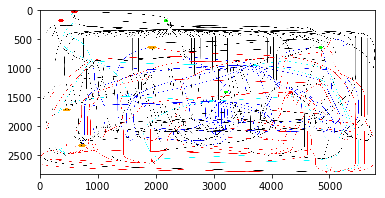

In [10]:
import pygraphviz as pgv
import matplotlib.pylab as plt
import matplotlib.image as mpimg
G = pgv.AGraph(agraph)
G.draw('N-O-H_network.png',prog='dot')
img = mpimg.imread('N-O-H_network.png')
plt.imshow(img)
plt.show()

This is totally unreadable in the notebook, but you can see that it is complex. Opening the file directly will make it a bit easier to make sense of, but the reality is that these networks are complex and difficult to interpret. Further analysis is needed to boil these down to something simpler.